In [1]:
import numpy as np

class SDCAClassifier:
    def __init__(self, loss="squared", lam=1e-3, max_iter=1000, verbose=0, tol=1e-7):
        self.loss = loss
        self.lam = lam
        self.max_iter = max_iter
        self.verbose = verbose
        self.w = None
        self.alpha = None
        self.losses_ = []
        self.tol = tol

    def fit(self, X, y):
        n, d = X.shape
        self.alpha = np.zeros(n)
        self.w = np.zeros(d)

        # convert labels for logistic loss to {-1,1}
        if self.loss == "log":
            y = 2*y - 1

        for it in range(self.max_iter):
            # randomly permute indices for one pass
            indices = np.random.permutation(n)
            for i in indices:
                xi = X[i]
                yi = y[i]

                # compute gradient w.r.t alpha_i
                if self.loss == "squared":
                    # squared loss: phi_i(u) = 0.5*(u - yi)^2
                    # dual update has closed form
                    # alpha_i_new = (yi - w^T xi) / (||xi||^2 + lambda*n)
                    delta = (yi - np.dot(self.w, xi) - self.alpha[i] / self.lam) / (np.linalg.norm(xi)**2 / self.lam + 1)
                elif self.loss == "log":
                    # logistic loss: phi_i(u) = log(1 + exp(-yi*u))
                    # dual update: use Newton step or closed form if possible
                    # for simplicity, use one Newton step
                    u = yi * np.dot(self.w, xi)
                    s = 1 / (1 + np.exp(u))
                    delta = (1 - s - self.alpha[i]) / (np.linalg.norm(xi)**2 / self.lam + 1)

                # update dual variable
                self.alpha[i] += delta

                # update primal w
                self.w += delta * xi / self.lam

            
            loss = self._compute_loss(X, y)
            self.losses_.append(loss)
            
            if self.verbose and (it+1) % 10 == 0:
                print(f"iter {it+1}, loss={loss:.6f}")
            if it > 0 and abs(self.losses_[-2] - self.losses_[-1]) < self.tol:
                break
            
        return self

    def _compute_loss(self, X, y):
        n = X.shape[0]
        pred = X @ self.w
        if self.loss == "squared":
            loss = np.mean(0.5*(pred - y)**2) + 0.5 * self.lam * np.linalg.norm(self.w)**2
        elif self.loss == "log":
            z = y * pred
            loss = np.mean(np.log(1 + np.exp(-z))) + 0.5 * self.lam * np.linalg.norm(self.w)**2
        return loss

    def predict(self, X):
        if self.loss == "squared":
            return (X @ self.w >= 0.5).astype(int)
        else:
            return (X @ self.w >= 0).astype(int)

    def predict_proba(self, X):
        if self.loss == "squared":
            pred = X @ self.w
            p = np.clip(pred, 0, 1)
            return np.stack([1-p, p], axis=1)
        else:
            pred = X @ self.w
            p = 1 / (1 + np.exp(-pred))
            return np.stack([1-p, p], axis=1)


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo

# Fetch dataset
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = (bank_marketing.data.targets == "yes").astype(int)  # convert yes/no -> 1/0

# One-hot encode categorical features
X = pd.get_dummies(X)

# Scale numeric features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y.values.ravel(), test_size=0.2, random_state=42
)

In [3]:
from sklearn.datasets import make_classification, make_regression
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt

In [4]:
classifier = SDCAClassifier(loss="squared", lam=1e-3, max_iter=5000, verbose=0)
classifier.fit(X_train, y_train)

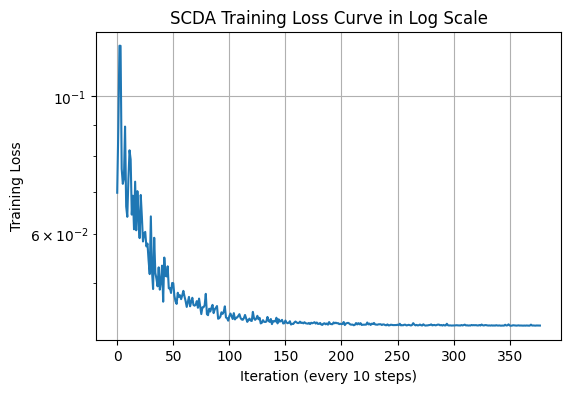

In [5]:
plt.figure(figsize=(6,4))
plt.plot(classifier.losses_)
plt.xlabel("Iteration (every 10 steps)")
plt.ylabel("Training Loss")
plt.title("SCDA Training Loss Curve in Log Scale")
plt.yscale('log')
plt.grid(True)
plt.show()

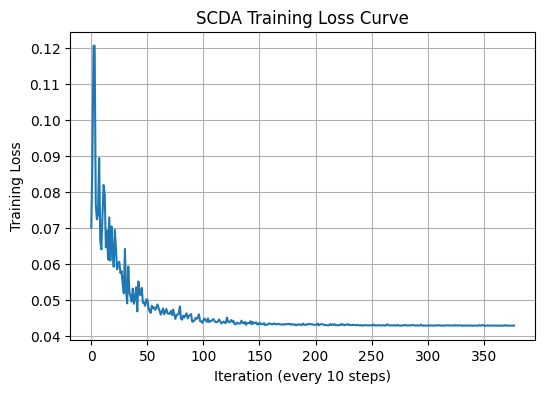

In [6]:
plt.figure(figsize=(6,4))
plt.plot(classifier.losses_)
plt.xlabel("Iteration (every 10 steps)")
plt.ylabel("Training Loss")
plt.title("SCDA Training Loss Curve")
#plt.yscale('log')
plt.grid(True)
plt.show()

In [7]:
classifier.losses_

[np.float64(0.06991000304222064),
 np.float64(0.08890635669398698),
 np.float64(0.12051009116650703),
 np.float64(0.12046630502871511),
 np.float64(0.0763960098522926),
 np.float64(0.07225847655424121),
 np.float64(0.07374082337044086),
 np.float64(0.08931957848564684),
 np.float64(0.0664582474638278),
 np.float64(0.06394380458055819),
 np.float64(0.07365774913544823),
 np.float64(0.08180873308206311),
 np.float64(0.07905928094278958),
 np.float64(0.06447208697998123),
 np.float64(0.06914307483217161),
 np.float64(0.061052062876042146),
 np.float64(0.07283857386023385),
 np.float64(0.060833048437810094),
 np.float64(0.07032020454905695),
 np.float64(0.0638876509063917),
 np.float64(0.05909589432846666),
 np.float64(0.06933677208021813),
 np.float64(0.06396674833443516),
 np.float64(0.0583647573079743),
 np.float64(0.060130200073649484),
 np.float64(0.06047517144810108),
 np.float64(0.05730773638777901),
 np.float64(0.057914382911367634),
 np.float64(0.05437149044455128),
 np.float64(0.

In [8]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8928452947030853


In [9]:
test_loss = classifier._compute_loss(X_test, y_test)
print("Test Loss:", test_loss)

Test Loss: 0.043645497892268015
